# Tuberculosis Classification CNN Model with Attention



## Import Libraries

In [7]:
import os
import cv2
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from PIL import Image
import torchvision.transforms as T

## Dataset Configuration

In [8]:
# Define dataset directories
DATASET_DIR = os.path.join('.', 'tuberculosis-dataset')
NORMAL_DIR  = os.path.join(DATASET_DIR, 'Normal')
TB_DIR      = os.path.join(DATASET_DIR, 'Tuberculosis')

print("NORMAL_DIR exists?", os.path.exists(NORMAL_DIR))
print("TB_DIR exists?", os.path.exists(TB_DIR))

NORMAL_DIR exists? True
TB_DIR exists? True


## Load and Preprocess Images

In [3]:
all_images = []
all_labels = []
IMAGE_SIZE = 256

# Load Normal images (label = 0)
for fname in os.listdir(NORMAL_DIR):
    filepath = os.path.join(NORMAL_DIR, fname)
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        all_images.append(img)
        all_labels.append(0)

# Load Tuberculosis images (label = 1)
for fname in os.listdir(TB_DIR):
    filepath = os.path.join(TB_DIR, fname)
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        all_images.append(img)
        all_labels.append(1)

all_images = np.array(all_images)
all_labels = np.array(all_labels)

print("Images shape:", all_images.shape)
print("Labels shape:", all_labels.shape)


Images shape: (4200, 256, 256)
Labels shape: (4200,)


## Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42
)

# Convert from [0,255] -> [0,1] for training
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32')  / 255.0

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (2940, 256, 256)
X_test shape: (1260, 256, 256)


## Balance Dataset with SMOTE

In [9]:
smote_engine = SMOTE(random_state=42)

# Flatten images for SMOTE (shape: (n_samples, 256*256))
num_train_samples = X_train.shape[0]
X_train_2D = X_train.reshape(num_train_samples, -1)

X_train_resampled_2D, y_train_resampled = smote_engine.fit_resample(X_train_2D, y_train)

# Reshape back to (N, H, W, 1)
X_train_resampled = X_train_resampled_2D.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

print("After SMOTE, X_train_resampled shape:", X_train_resampled.shape)
print("After SMOTE, y_train_resampled shape:", y_train_resampled.shape)
unique_vals, counts = np.unique(y_train_resampled, return_counts=True)
print("Label distribution:", dict(zip(unique_vals, counts)))


After SMOTE, X_train_resampled shape: (4914, 256, 256, 1)
After SMOTE, y_train_resampled shape: (4914,)
Label distribution: {np.int64(0): np.int64(2457), np.int64(1): np.int64(2457)}


## Dataset Class Distribution

C:\Users\dell\AppData\Local\Temp\ipykernel_8228\280423579.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_before, x='Class', y='Count', palette='viridis')
C:\Users\dell\AppData\Local\Temp\ipykernel_8228\280423579.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_after, x='Class', y='Count', palette='viridis')


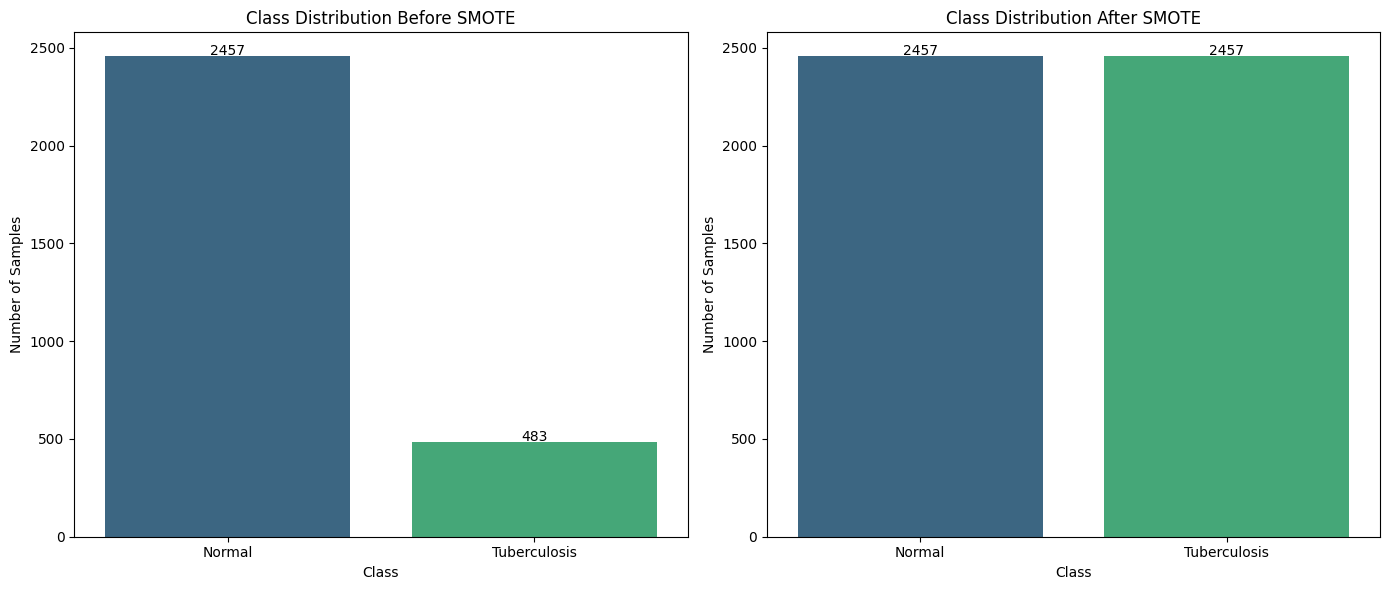

C:\Users\dell\AppData\Local\Temp\ipykernel_8228\280423579.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_test, x='Class', y='Count', palette='viridis')


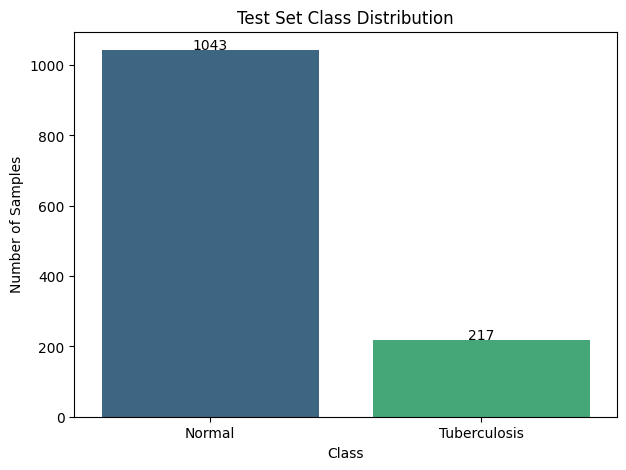

In [ ]:
plt.figure(figsize=(14, 6))

# Before SMOTE distribution
plt.subplot(1, 2, 1)
original_vals, original_counts = np.unique(y_train, return_counts=True)
sns.barplot(x=['Normal', 'Tuberculosis'],
            y=original_counts,
            hue=['Normal', 'Tuberculosis'],
            palette='viridis')
plt.title('Class Distribution Before SMOTE')
plt.ylabel('Number of Samples')
plt.legend([],[], frameon=False)  # Disable legend
for i, count in enumerate(original_counts):
    plt.text(i, count + 5, str(count), ha='center')

# After SMOTE distribution
plt.subplot(1, 2, 2)
resampled_vals, resampled_counts = np.unique(y_train_resampled, return_counts=True)
sns.barplot(x=['Normal', 'Tuberculosis'],
            y=resampled_counts,
            hue=['Normal', 'Tuberculosis'],
            palette='viridis')
plt.title('Class Distribution After SMOTE')
plt.ylabel('Number of Samples')
plt.legend([],[], frameon=False)
for i, count in enumerate(resampled_counts):
    plt.text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

# Test set distribution
plt.figure(figsize=(7, 5))
test_vals, test_counts = np.unique(y_test, return_counts=True)
sns.barplot(x=['Normal', 'Tuberculosis'],
            y=test_counts,
            hue=['Normal', 'Tuberculosis'],
            palette='viridis')
plt.title('Test Set Class Distribution')
plt.ylabel('Number of Samples')
plt.legend([],[], frameon=False)
for i, count in enumerate(test_counts):
    plt.text(i, count + 2, str(count), ha='center')
plt.show()

## Visualize Sample Images from Dataset

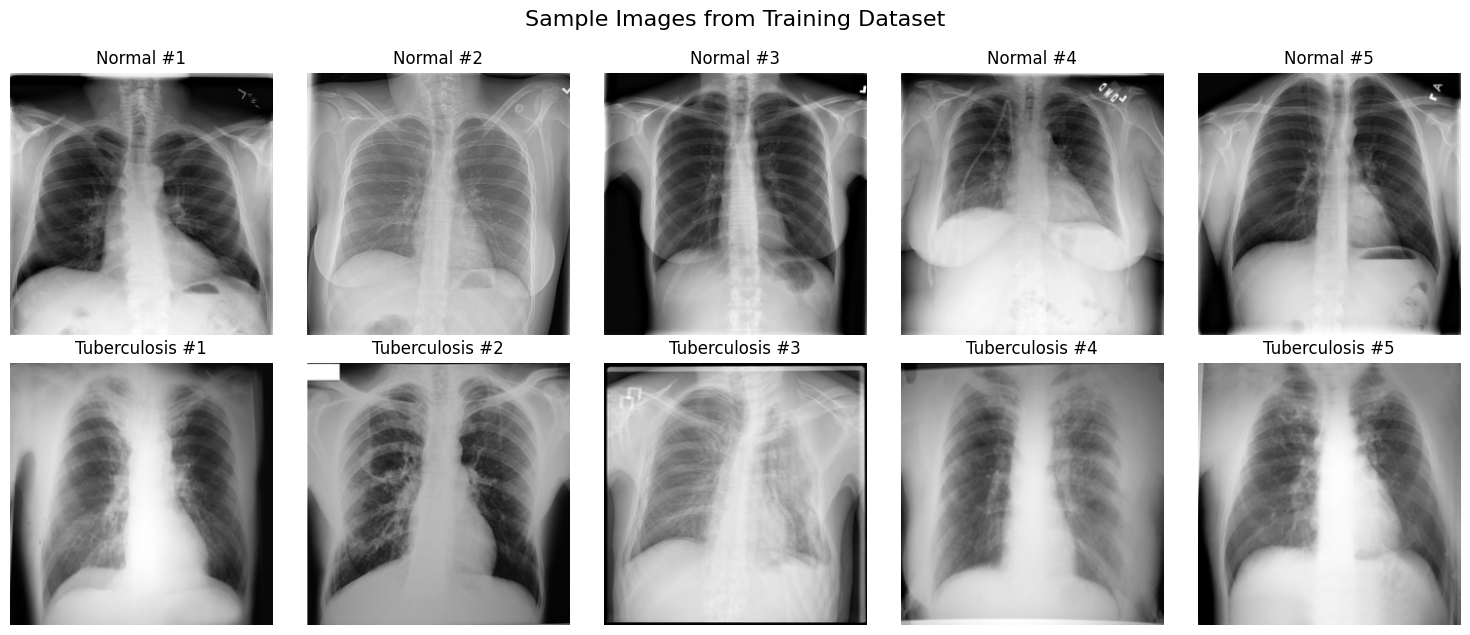

In [8]:
# Visualize sample images from each class
plt.figure(figsize=(15, 6))

# Find indices of normal and TB samples
normal_indices = np.where(y_train_resampled == 0)[0]
tb_indices = np.where(y_train_resampled == 1)[0]

# Sample 5 images from each class
normal_samples = np.random.choice(normal_indices, 5, replace=False)
tb_samples = np.random.choice(tb_indices, 5, replace=False)

# Plot Normal samples
for i, idx in enumerate(normal_samples):
    plt.subplot(2, 5, i+1)
    img = np.squeeze(X_train_resampled[idx])
    plt.imshow(img, cmap='gray')
    plt.title(f"Normal #{i+1}")
    plt.axis('off')

# Plot TB samples
for i, idx in enumerate(tb_samples):
    plt.subplot(2, 5, i+6)
    img = np.squeeze(X_train_resampled[idx])
    plt.imshow(img, cmap='gray')
    plt.title(f"Tuberculosis #{i+1}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Sample Images from Training Dataset", y=1.05, fontsize=16)
plt.show()

## Image Intensity Analysis

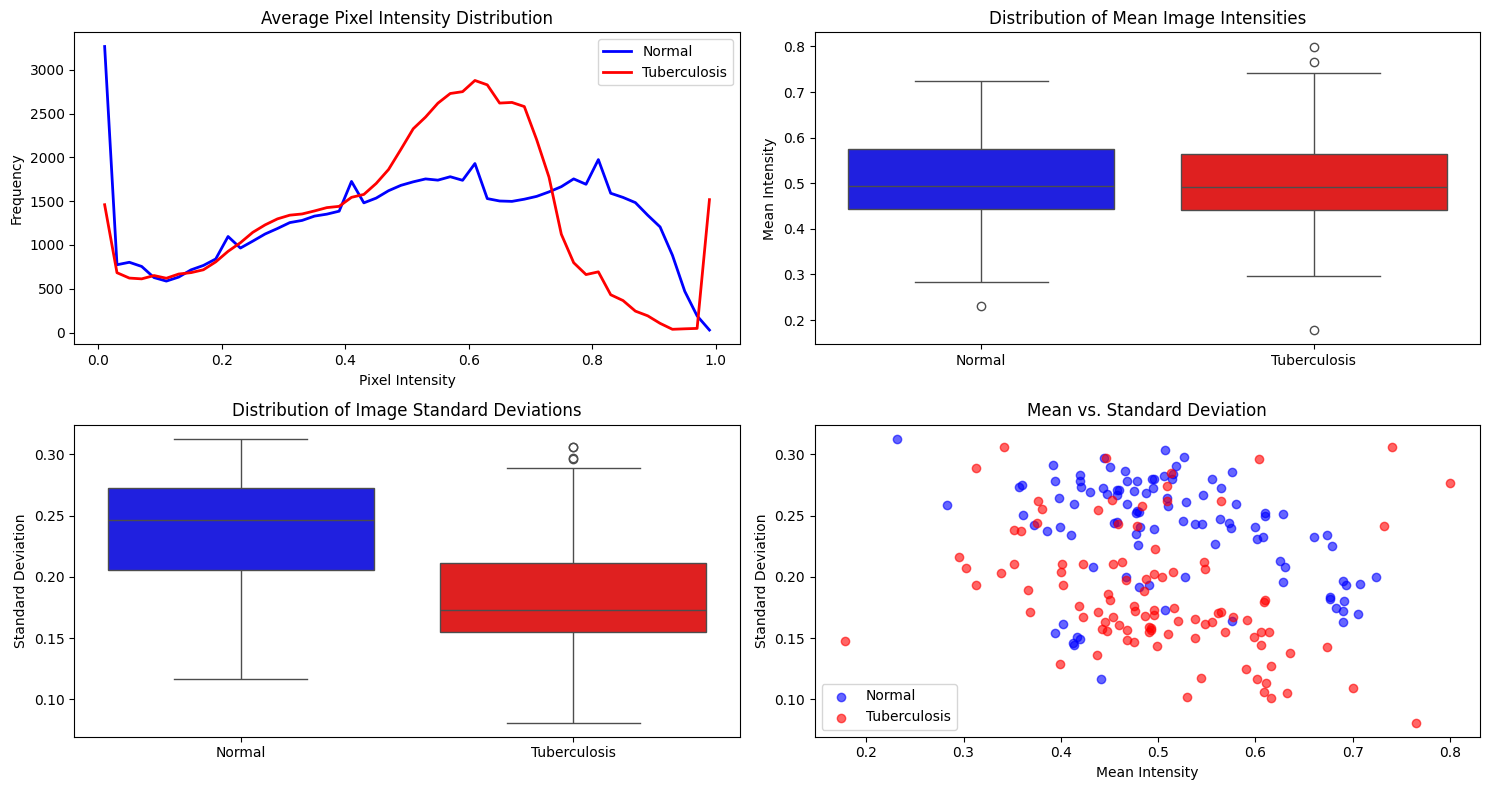

In [9]:
# Analyze image intensity distributions
plt.figure(figsize=(15, 8))

# Randomly sample images for analysis
n_samples = min(100, len(normal_indices), len(tb_indices))
normal_analysis = np.random.choice(normal_indices, n_samples, replace=False)
tb_analysis = np.random.choice(tb_indices, n_samples, replace=False)

# Compute mean intensity histograms for each class
normal_hist = np.zeros(50)
tb_hist = np.zeros(50)

for idx in normal_analysis:
    img = np.squeeze(X_train_resampled[idx])
    hist, _ = np.histogram(img, bins=50, range=(0, 1))
    normal_hist += hist
    
for idx in tb_analysis:
    img = np.squeeze(X_train_resampled[idx])
    hist, _ = np.histogram(img, bins=50, range=(0, 1))
    tb_hist += hist

# Normalize the histograms
normal_hist = normal_hist / n_samples
tb_hist = tb_hist / n_samples

# Plot the average intensity histograms
plt.subplot(2, 2, 1)
bin_edges = np.linspace(0, 1, 51)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, normal_hist, label='Normal', color='blue', linewidth=2)
plt.plot(bin_centers, tb_hist, label='Tuberculosis', color='red', linewidth=2)
plt.legend()
plt.title('Average Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Compute mean and standard deviation of pixel values for each class
normal_means = [np.mean(np.squeeze(X_train_resampled[idx])) for idx in normal_analysis]
normal_stds = [np.std(np.squeeze(X_train_resampled[idx])) for idx in normal_analysis]
tb_means = [np.mean(np.squeeze(X_train_resampled[idx])) for idx in tb_analysis]
tb_stds = [np.std(np.squeeze(X_train_resampled[idx])) for idx in tb_analysis]

# Plot mean intensity boxplot
plt.subplot(2, 2, 2)
sns.boxplot(data=[normal_means, tb_means], palette=['blue', 'red'])
plt.xticks([0, 1], ['Normal', 'Tuberculosis'])
plt.title('Distribution of Mean Image Intensities')
plt.ylabel('Mean Intensity')

# Plot standard deviation boxplot
plt.subplot(2, 2, 3)
sns.boxplot(data=[normal_stds, tb_stds], palette=['blue', 'red'])
plt.xticks([0, 1], ['Normal', 'Tuberculosis'])
plt.title('Distribution of Image Standard Deviations')
plt.ylabel('Standard Deviation')

# Scatter plot of mean vs std
plt.subplot(2, 2, 4)
plt.scatter(normal_means, normal_stds, alpha=0.6, label='Normal', color='blue')
plt.scatter(tb_means, tb_stds, alpha=0.6, label='Tuberculosis', color='red')
plt.xlabel('Mean Intensity')
plt.ylabel('Standard Deviation')
plt.title('Mean vs. Standard Deviation')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Create PyTorch Dataset and DataLoaders

In [10]:
class TBChestXrayDataset(Dataset):
    """
    A PyTorch Dataset class for Tuberculosis Chest X-ray classification,
    capable of applying transforms (data augmentation).
    """
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (np.array): (N, H, W, 1) or (N, H, W) array of grayscale images.
            labels (np.array): (N,) array of labels (0 or 1).
            transform (callable, optional).
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Extract image, label
        raw_image = self.images[idx]  # shape: (H, W, 1) or (H, W)
        label_val = self.labels[idx].astype('float32')

        # If shape is (H, W, 1), we can squeeze to (H, W)
        if len(raw_image.shape) == 3 and raw_image.shape[2] == 1:
            raw_image = np.squeeze(raw_image, axis=-1)

        # Convert to PIL Image for transforms
        pil_image = Image.fromarray((raw_image * 255).astype('uint8'), mode='L')

        if self.transform:
            img_tensor = self.transform(pil_image)  # transforms yield torch.Tensor [C,H,W]
        else:
            # Default: turn into PyTorch tensor with shape [1,H,W]
            img_tensor = torch.tensor(raw_image, dtype=torch.float32).unsqueeze(0)

        label_tensor = torch.tensor(label_val, dtype=torch.float32)
        return img_tensor, label_tensor

# Define transforms for data augmentation
train_transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.1),  # Some TB patterns are orientation-sensitive but adding slight variability
    T.RandomRotation(degrees=15),
    T.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Simulate different patient positioning
    T.ColorJitter(brightness=0.15, contrast=0.15),  # Simulate different X-ray exposure settings
    T.RandomAutocontrast(p=0.2),  # Helps with different X-ray machine calibrations
    T.ToTensor(),
    T.RandomErasing(p=0.2, scale=(0.02, 0.1))  # Simulate occlusions/small artifacts
])

# For test set, just convert to tensor (no augmentation)
test_transforms = T.Compose([
    T.ToTensor()
])

# Create datasets
train_dataset = TBChestXrayDataset(X_train_resampled, y_train_resampled, transform=train_transforms)
test_4D = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
test_dataset  = TBChestXrayDataset(test_4D, y_test, transform=test_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))


Number of training samples: 4914
Number of testing samples: 1260


## Spatial Attention and CNN Model Definition

In [11]:
class SpatialAttention(nn.Module):
    """
    A simple spatial attention module inspired by CBAM:
    - Takes an input feature map [B,C,H,W].
    - Produces an attention map [B,1,H,W].
    - multiply this attention map by the input feature map to emphasize important regions.
    """
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv2d = nn.Conv2d(2, 1, kernel_size=kernel_size, 
                                padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):
        # input_tensor shape: [B, C, H, W]
        # Compute average and max along the channel dimension
        avg_out = torch.mean(input_tensor, dim=1, keepdim=True)           # [B,1,H,W]
        max_out, _ = torch.max(input_tensor, dim=1, keepdim=True)         # [B,1,H,W]
        combined = torch.cat([avg_out, max_out], dim=1)                   # [B,2,H,W]

        # Pass through conv layer -> single-channel -> sigmoid
        attention_map = self.conv2d(combined)                             # [B,1,H,W]
        attention_map = self.sigmoid(attention_map)
        return attention_map

class SimpleAttentionCNN(nn.Module):
    """
    A variant of the SimpleCNN that includes a SpatialAttention block.
    """
    def __init__(self):
        super(SimpleAttentionCNN, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Added padding
            nn.BatchNorm2d(16),  # Add BatchNorm
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),  # Add BatchNorm
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.2),  # Added spatial dropout
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Add BatchNorm
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.3),  # Added spatial dropout
        )

        # Spatial attention module
        self.spatial_attention = SpatialAttention(kernel_size=7)

        # Classifier with increased dropout
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 64),  # Dimensions updated because of padding
            nn.BatchNorm1d(64),  # Added batch normalization
            nn.ReLU(),
            nn.Dropout(0.7),  # Increased dropout from 0.5 to 0.7
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Extract deep features
        features = self.feature_extractor(x)           # [B,64,32,32] with padding
        attention_map = self.spatial_attention(features) # [B,1,32,32]

        # Apply attention
        attended_features = features * attention_map   # Element-wise multiplication

        # Classify
        output = self.classifier(attended_features)    # [B,1]
        return output, attention_map

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleAttentionCNN().to(device)

print(model)

SimpleAttentionCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.2, inplace=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout2d(p=0.3, inplace=False)
  )
  (spatial_attention): SpatialAttention(
    (conv2d): Conv2d(2,

## Loss Function and Optimizer Setup

In [12]:
# Define the loss function (before training loop)
loss_function = nn.BCELoss()

# Add weight decay to combat overfitting
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)  # Increased weight decay

# Change learning rate scheduler to monitor validation metrics
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=2, min_lr=1e-5, verbose=True
)

f:\Conda\envs\py310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Attention Focus Loss

In [13]:
def attention_focus_loss(attention_map):
    try:
        # Safely calculate focus loss even if attention map has unexpected values
        numerator = torch.sum(attention_map**2, dim=[2,3])
        denominator = torch.sum(attention_map, dim=[2,3])
        
        # Prevent division by zero with a small epsilon
        epsilon = 1e-7
        ratio = numerator / (denominator + epsilon)
        
        return -torch.mean(ratio)
    except Exception as e:
        print(f"Warning: Error in attention focus loss: {e}")
        # Return zero loss if calculation fails
        return torch.tensor(0.0, device=attention_map.device)

## Training and Evaluation Functions

In [14]:
def train_one_epoch(network, dataloader, optimizer, criterion, device, focus_weight=0.2):
    network.train()
    total_loss = 0.0
    total_cls_loss = 0.0
    total_focus_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_images, batch_labels in dataloader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device).view(-1, 1)  # shape: [B,1]
        
        optimizer.zero_grad()

        # Forward pass
        outputs, attention_maps = network(batch_images)
        
        # Classification loss
        cls_loss = criterion(outputs, batch_labels)
        
        # Attention focus loss
        focus_loss = attention_focus_loss(attention_maps)
        
        # Combined loss
        loss = cls_loss + focus_weight * focus_loss
        
        # Backward and optimize with gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item() * batch_images.size(0)
        total_cls_loss += cls_loss.item() * batch_images.size(0)
        total_focus_loss += focus_loss.item() * batch_images.size(0)
        
        predicted_classes = (outputs >= 0.5).float()  # threshold at 0.5
        correct_predictions += (predicted_classes == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    avg_loss = total_loss / total_samples
    avg_cls_loss = total_cls_loss / total_samples
    avg_focus_loss = total_focus_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    # Return all metrics for monitoring
    return avg_loss, accuracy, {"cls_loss": avg_cls_loss, "focus_loss": avg_focus_loss}

def evaluate_model(network, dataloader, criterion, device):
    network.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_attention_maps = []
    
    with torch.no_grad():
        for batch_images, batch_labels in dataloader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device).view(-1, 1)
            
            # Forward pass
            outputs, attention_maps = network(batch_images)
            
            # Store attention maps for inspection if needed
            all_attention_maps.append(attention_maps.cpu())
            
            # Classification loss only for evaluation
            loss = criterion(outputs, batch_labels)
            
            total_loss += loss.item() * batch_images.size(0)
            
            predicted_classes = (outputs >= 0.5).float()
            correct_predictions += (predicted_classes == batch_labels).sum().item()
            total_samples += batch_labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

## Training Loop

Training on 4176 samples, validating on 738 samples
[Epoch 1/25] Train Loss: 0.2377 (Cls: 0.4325, Focus: -0.9740), Train Acc: 0.8065, Val Loss: 0.3558, Val Acc: 0.8306
Model improved at epoch 1, saved to tb_chest_xray_attention_best.pt
[Epoch 2/25] Train Loss: 0.1371 (Cls: 0.3362, Focus: -0.9957), Train Acc: 0.8578, Val Loss: 0.2319, Val Acc: 0.9228
Model improved at epoch 2, saved to tb_chest_xray_attention_best.pt
[Epoch 3/25] Train Loss: 0.1252 (Cls: 0.3244, Focus: -0.9957), Train Acc: 0.8695, Val Loss: 0.9040, Val Acc: 0.5881
[Epoch 4/25] Train Loss: 0.1118 (Cls: 0.3108, Focus: -0.9949), Train Acc: 0.8829, Val Loss: 0.3449, Val Acc: 0.8144
[Epoch 5/25] Train Loss: 0.1218 (Cls: 0.3206, Focus: -0.9941), Train Acc: 0.8764, Val Loss: 0.4908, Val Acc: 0.7480
[Epoch 6/25] Train Loss: 0.0685 (Cls: 0.2675, Focus: -0.9951), Train Acc: 0.9004, Val Loss: 0.1502, Val Acc: 0.9472
Model improved at epoch 6, saved to tb_chest_xray_attention_best.pt
[Epoch 7/25] Train Loss: 0.0305 (Cls: 0.2296, Fo

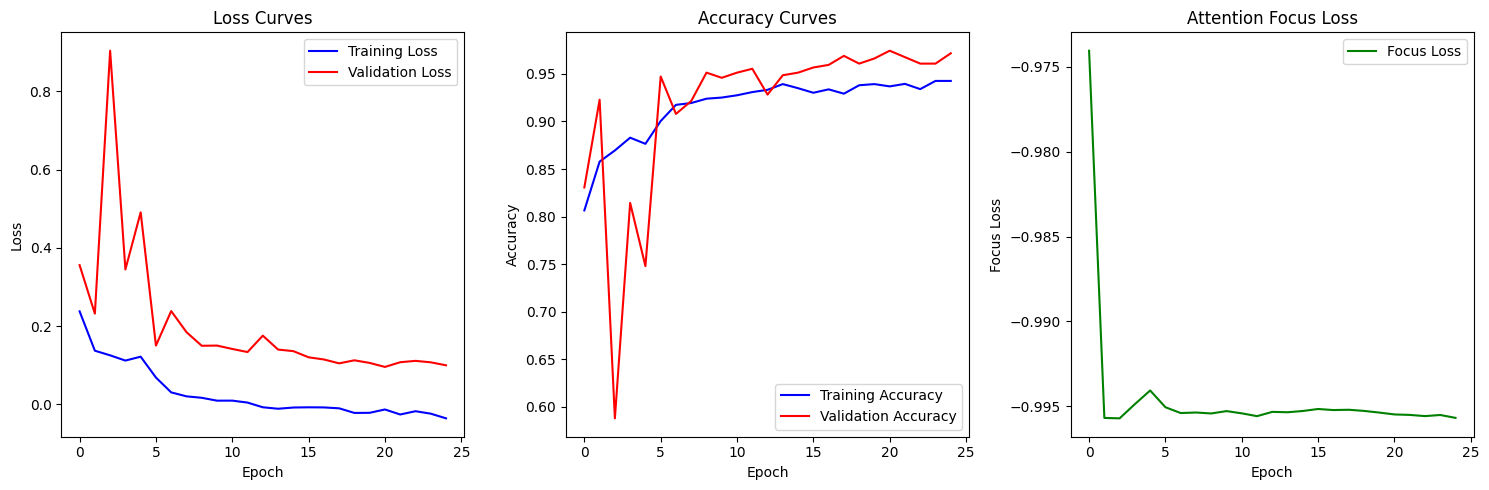

C:\Users\dell\AppData\Local\Temp\ipykernel_24672\2792019044.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Loaded best model from tb_chest_xray_attention_best.pt


In [ ]:
num_epochs = 25
best_accuracy = 0.0
best_model_path = "tb_chest_xray_attention_best_test.pt"
patience = 4  # For early stopping
patience_counter = 0
focus_weight = 0.2  # Weight for attention focus loss

# Split some training data for validation
train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader_split = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

# History tracking for plotting
train_losses = []
val_losses = []
train_accs = []
val_accs = []
focus_losses = []

print(f"Training on {train_size} samples, validating on {val_size} samples")

for epoch in range(num_epochs):
    # Train with attention focus loss
    train_loss, train_acc, loss_details = train_one_epoch(
        model, train_loader_split, optimizer, loss_function, device, focus_weight=focus_weight
    )
    
    # Store metrics for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    focus_losses.append(loss_details['focus_loss'])
    
    # Validate
    val_loss, val_acc = evaluate_model(
        model, val_loader, loss_function, device
    )
    
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Using validation accuracy for LR scheduling
    lr_scheduler.step(val_acc)
    
    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} (Cls: {loss_details['cls_loss']:.4f}, Focus: {loss_details['focus_loss']:.4f}), "
          f"Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save the best model based on validation accuracy
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Model improved at epoch {epoch+1}, saved to {best_model_path}")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Plot training curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 3, 2)
plt.plot(train_accs, 'b-', label='Training Accuracy')
plt.plot(val_accs, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.subplot(1, 3, 3)
plt.plot(focus_losses, 'g-', label='Focus Loss')
plt.xlabel('Epoch')
plt.ylabel('Focus Loss')
plt.legend()
plt.title('Attention Focus Loss')

plt.tight_layout()
plt.show()

# Load the best model for evaluation
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from {best_model_path}")

## Model Evaluation

In [16]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_predictions = []
all_ground_truths = []
all_raw_outputs = []

with torch.no_grad():
    for images_batch, labels_batch in test_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        outputs, attention_map = model(images_batch)
        preds = (outputs >= 0.5).float()
        
        all_predictions.extend(preds.cpu().numpy().flatten())
        all_ground_truths.extend(labels_batch.cpu().numpy().flatten())
        all_raw_outputs.extend(outputs.cpu().numpy().flatten())

print("CLASSIFICATION REPORT:")
print(classification_report(all_ground_truths, all_predictions, digits=4))

C:\Users\dell\AppData\Local\Temp\ipykernel_24672\4009156125.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         0.0     0.9932    0.9818    0.9875      1043
         1.0     0.9170    0.9677    0.9417       217

    accuracy                         0.9794      1260
   macro avg     0.9551    0.9748    0.9646      1260
weighted avg     0.9801    0.9794    0.9796      1260



## Confusion Matrix Visualization

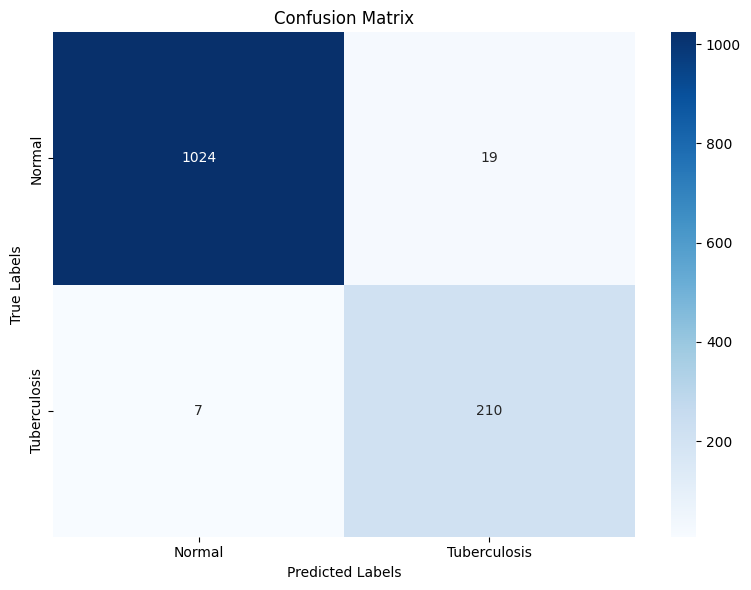

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(8, 6))

# Confusion Matrix as a heatmap
cm = confusion_matrix(all_ground_truths, all_predictions)
class_names = ['Normal', 'Tuberculosis']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

## ROC Curve Analysis

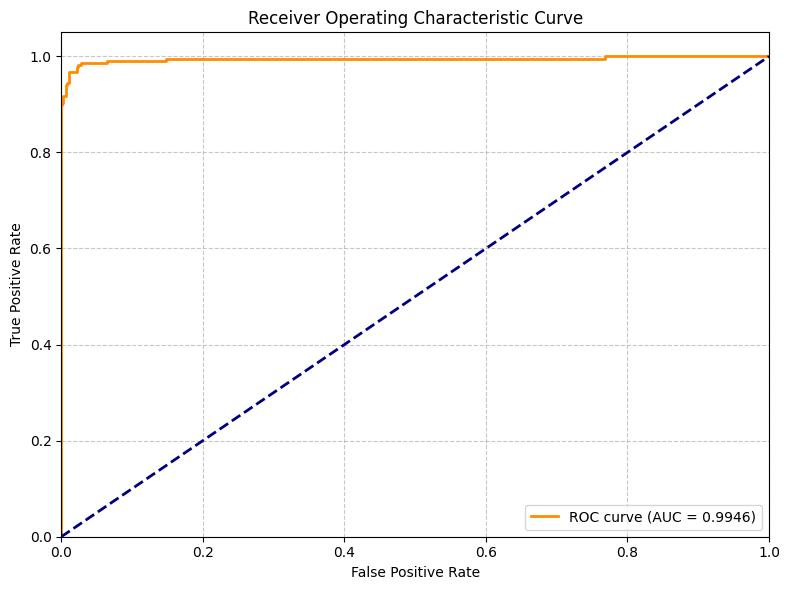

AUC-ROC Score: 0.9946


In [18]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(all_ground_truths, all_raw_outputs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"AUC-ROC Score: {roc_auc:.4f}")

## Precision-Recall Curve

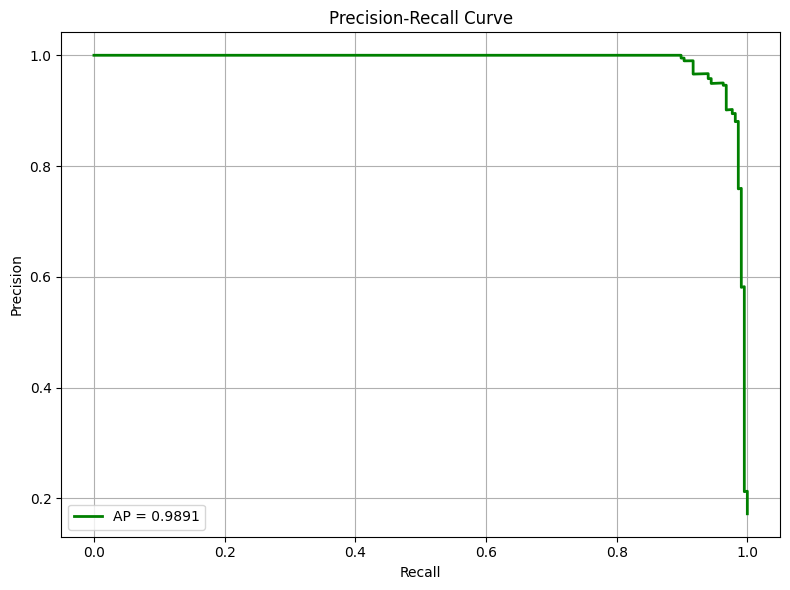

Average Precision Score: 0.9891


In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_ground_truths, all_raw_outputs)
avg_precision = average_precision_score(all_ground_truths, all_raw_outputs)
plt.plot(recall, precision, color='green', lw=2, label=f'AP = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Average Precision Score: {avg_precision:.4f}")

## Classification Metrics by Class

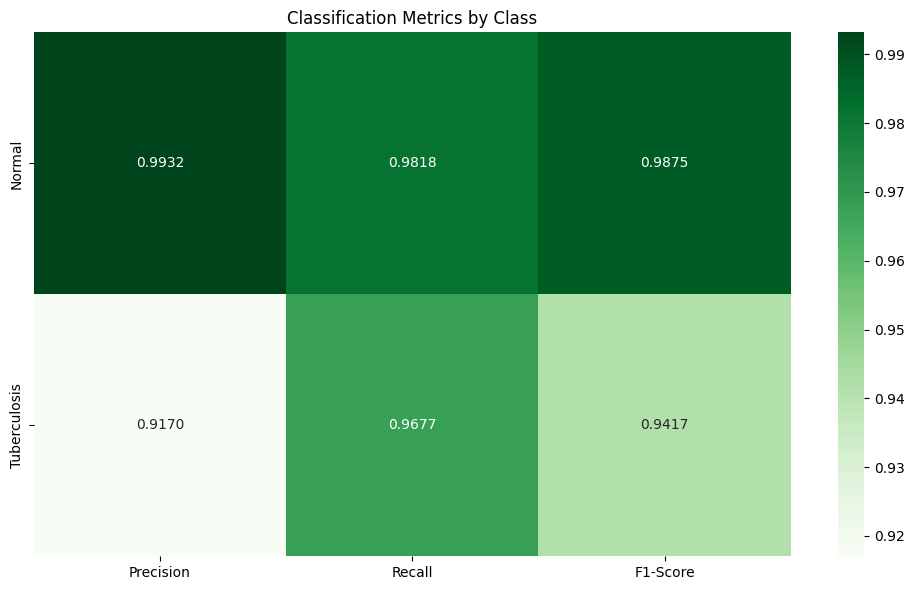

Overall Metrics:
Accuracy: 0.9794
Macro F1-Score: 0.9646
Weighted F1-Score: 0.9796


In [20]:
# Classification Report as a heatmap
plt.figure(figsize=(10, 6))

report = classification_report(all_ground_truths, all_predictions, target_names=class_names, 
                             output_dict=True, digits=4)
report_data = []
for i, class_name in enumerate(class_names):
    metrics = report[class_name]
    report_data.append([metrics['precision'], metrics['recall'], metrics['f1-score']])

report_df = pd.DataFrame(report_data, index=class_names, 
                       columns=['Precision', 'Recall', 'F1-Score'])
sns.heatmap(report_df, annot=True, fmt='.4f', cmap='Greens')
plt.title('Classification Metrics by Class')

plt.tight_layout()
plt.show()

# Print overall metrics
print(f"Overall Metrics:")
print(f"Accuracy: {report['accuracy']:.4f}")
print(f"Macro F1-Score: {report['macro avg']['f1-score']:.4f}")
print(f"Weighted F1-Score: {report['weighted avg']['f1-score']:.4f}")

## Utility Function for Attention Map Visualization

In [21]:
# Utility function to get sample predictions with attention maps
def get_sample_prediction_with_attention(model, dataloader, num_samples=3, device=device):
    model.eval()
    samples = []
    class_samples = {0: [], 1: []}
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs, attention_maps = model(images)
            preds = (outputs >= 0.5).float()
            
            # Get indices where prediction matches ground truth
            correct_indices = (preds.flatten() == labels).nonzero(as_tuple=True)[0]
            
            for idx in correct_indices:
                class_label = int(labels[idx].item())
                if len(class_samples[class_label]) < num_samples:
                    class_samples[class_label].append({
                        'image': images[idx].cpu(),
                        'attention': attention_maps[idx].cpu(),
                        'pred': outputs[idx].item(),
                        'label': class_label
                    })
            
            if all(len(samples) >= num_samples for samples in class_samples.values()):
                break
                
    return class_samples

# Utility Function for Attention Map Visualization

In [29]:
# Utility function to get sample predictions with attention maps
def get_sample_prediction_with_attention(model, dataloader, num_samples=3, device=device):
    model.eval()
    samples = []
    class_samples = {0: [], 1: []}
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs, attention_maps = model(images)
            preds = (outputs >= 0.5).float()
            
            # Get indices where prediction matches ground truth
            correct_indices = (preds.flatten() == labels).nonzero(as_tuple=True)[0]
            
            for idx in correct_indices:
                class_label = int(labels[idx].item())
                if len(class_samples[class_label]) < num_samples:
                    class_samples[class_label].append({
                        'image': images[idx].cpu(),
                        'attention': attention_maps[idx].cpu(),
                        'pred': outputs[idx].item(),
                        'label': class_label
                    })
            
            if all(len(samples) >= num_samples for samples in class_samples.values()):
                break
                
    return class_samples

## Attention Heatmap Comparison

In [30]:
# Create a more detailed visualization of attention heatmaps
plt.figure(figsize=(12, 10))

# Select one sample from each class
normal_sample = class_samples[0][0]
tb_sample = class_samples[1][0]

# Normal class
plt.subplot(2, 2, 1)
normal_img = normal_sample['image'].squeeze().numpy()
plt.imshow(normal_img, cmap='gray')
plt.title(f"Normal X-ray\nConfidence: {normal_sample['pred']:.4f}")
plt.axis('off')

plt.subplot(2, 2, 2)
normal_attention = normal_sample['attention'].squeeze().numpy()
plt.imshow(normal_attention, cmap='hot')
plt.colorbar(label='Attention Weight')
plt.title("Normal Attention Heatmap")
plt.axis('off')

# TB class
plt.subplot(2, 2, 3)
tb_img = tb_sample['image'].squeeze().numpy()
plt.imshow(tb_img, cmap='gray')
plt.title(f"Tuberculosis X-ray\nConfidence: {tb_sample['pred']:.4f}")
plt.axis('off')

plt.subplot(2, 2, 4)
tb_attention = tb_sample['attention'].squeeze().numpy()
plt.imshow(tb_attention, cmap='hot')
plt.colorbar(label='Attention Weight')
plt.title("Tuberculosis Attention Heatmap")
plt.axis('off')

plt.tight_layout()
plt.suptitle("Attention Heatmap Comparison: Normal vs. Tuberculosis", y=0.98, fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

NameError: name 'class_samples' is not defined

<Figure size 1200x1000 with 0 Axes>

## Class Precision Visualization

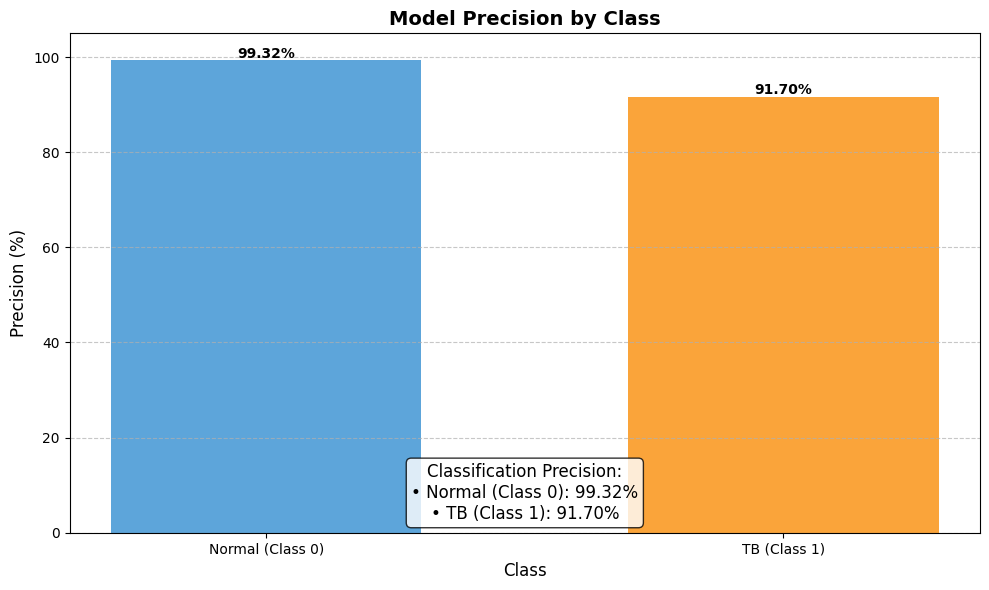

Model Precision Metrics:
- Normal (Class 0): 99.32% precision
- TB (Class 1): 91.70% precision


In [23]:
# Visualization of class precision metrics calculated from model predictions
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score

# Calculate precision for each class from model predictions
overall_precision = precision_score(all_ground_truths, all_predictions, average=None)
normal_precision = overall_precision[0] * 100  # Class 0 (Normal)
tb_precision = overall_precision[1] * 100      # Class 1 (TB)

# Alternative calculation from confusion matrix if needed
cm = confusion_matrix(all_ground_truths, all_predictions)
tn, fp, fn, tp = cm.ravel()
normal_precision_cm = tn / (tn + fn) * 100 if (tn + fn) > 0 else 0
tb_precision_cm = tp / (tp + fp) * 100 if (tp + fp) > 0 else 0

# For visualization - use the precision_score results
classes = ['Normal (Class 0)', 'TB (Class 1)']
precision_values = [normal_precision, tb_precision]
colors = ['#5DA5DA', '#FAA43A']  # Blue for Normal, Orange for TB

# Create the visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, precision_values, color=colors, width=0.6)

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f}%', ha='center', fontweight='bold')

# Add labels and title
plt.xlabel('Class', fontsize=12)
plt.ylabel('Precision (%)', fontsize=12)
plt.title('Model Precision by Class', fontsize=14, fontweight='bold')
plt.ylim(0, 105)  # Set y-axis limit to accommodate text labels

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text box with precision information
textstr = '\n'.join([
    'Classification Precision:',
    f'• Normal (Class 0): {normal_precision:.2f}%',
    f'• TB (Class 1): {tb_precision:.2f}%'
])
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.5, 0.02, textstr, transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='bottom', horizontalalignment='center',
         bbox=props)

plt.tight_layout()
plt.show()

# Print the calculated values
print("Model Precision Metrics:")
print(f"- Normal (Class 0): {normal_precision:.2f}% precision")
print(f"- TB (Class 1): {tb_precision:.2f}% precision")